# **Modell zur Einordnung von Velozähldaten in der Stadt Zürich**

In [ ]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install Requests BeautifulSoup4 pandas numpy geopandas statsmodels scipy scikit-learn matplotlib seaborn

In [ ]:
#Import libraries
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance

# common visualization module
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

# numeric library
import numpy as np

import os
import pandas as pd
from time import time as timer
import tarfile

import tensorflow as tf

**Datenimport**


In [ ]:
### Loading data
weather_raw = pd.read_csv('/content/drive/MyDrive/CAS/VeloCheckZH/data/weather/ogd-smn_reh_d_historical.csv', sep=";")
holidays = pd.read_csv('/content/drive/MyDrive/CAS/VeloCheckZH/data/holidays/schulferien.csv')
countingdata_raw_2022 = pd.read_csv('/content/drive/MyDrive/CAS/VeloCheckZH/data/counts/2022_verkehrszaehlungen_werte_fussgaenger_velo.csv')
countingdata_raw_2023 = pd.read_csv('/content/drive/MyDrive/CAS/VeloCheckZH/data/counts/2023_verkehrszaehlungen_werte_fussgaenger_velo.csv')
countingdata_raw_2024 = pd.read_csv('/content/drive/MyDrive/CAS/VeloCheckZH/data/counts/2024_verkehrszaehlungen_werte_fussgaenger_velo.csv')

In [ ]:
#Markiere Ferientage und Feiertage
holidays.drop(columns=['created_date'], inplace=True)
holidays['Startdatum'] = pd.to_datetime(holidays['start_date'])
holidays['Enddatum'] = pd.to_datetime(holidays['end_date'])
holidays.drop(columns=['summary','start_date', 'end_date'], inplace=True)



In [ ]:
# Create a date range for 2022 - 2024
all_dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')

# Create a DataFrame with all dates
holiday_status = pd.DataFrame({'Datum': all_dates})

# Initialize a column to mark if a day is a holiday
holiday_status['is_holiday'] = False

# Convert 'Datum' in holiday_status to datetime for comparison and localize to UTC
holiday_status['Zeitstempel'] = pd.to_datetime(holiday_status['Datum']).dt.tz_localize('UTC')

# Iterate through each holiday period and mark the dates within that range
for index, row in holidays.iterrows():
    start_date = row['Startdatum']
    end_date = row['Enddatum']
    # Ensure the types are datetime before comparison (already UTC-aware from holidays)
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Subtract one day from the end date as requested
    end_date = end_date - pd.Timedelta(days=1)

    holiday_status.loc[(holiday_status['Zeitstempel'] >= start_date) & (holiday_status['Zeitstempel'] <= end_date), 'is_holiday'] = True


In [ ]:
display(holiday_status.head())

,Datum,is_holiday,Zeitstempel
0,2022-01-01,True,2022-01-01 00:00:00+00:00
1,2022-01-02,True,2022-01-02 00:00:00+00:00
2,2022-01-03,False,2022-01-03 00:00:00+00:00
3,2022-01-04,False,2022-01-04 00:00:00+00:00
4,2022-01-05,False,2022-01-05 00:00:00+00:00


**Aufbereitung Wetterdaten**

In [ ]:

weather_all = weather_raw[['reference_timestamp', 'rka150d0', 'tre200d0', 'tre200dn', 'tre200dx']].copy()

# Rename the columns
weather_all = weather_all.rename(columns={
    'reference_timestamp': 'Zeitstempel',
    'rka150d0': 'Niederschlag',
    'tre200d0': 'Temperatur Durchschnitt',
    'tre200dn': 'Temperatur min',
    'tre200dx': 'Temperatur max'
})

# Convert 'Datum' to datetime format
weather_all['Datum'] = pd.to_datetime(weather_all['Zeitstempel'], format='%d.%m.%Y %H:%M')

# Convert other columns to numeric, coercing errors
for col in ['Niederschlag', 'Temperatur Durchschnitt', 'Temperatur min', 'Temperatur max']:
    weather_all[col] = pd.to_numeric(weather_all[col], errors='coerce')

#Filter for the years 2022 - 2024 and reset index
weather = weather_all[(weather_all['Datum'].dt.year >= 2022) & (weather_all['Datum'].dt.year <= 2024)].reset_index(drop=True)

# Display the first few rows of the new dataframe
display(weather.tail())

,Zeitstempel,Niederschlag,Temperatur Durchschnitt,Temperatur min,Temperatur max,Datum
1091,27.12.2024 00:00,0.0,-1.2,-2.0,-0.3,2024-12-27
1092,28.12.2024 00:00,0.0,-1.5,-2.3,-0.4,2024-12-28
1093,29.12.2024 00:00,0.0,-1.7,-2.7,1.0,2024-12-29
1094,30.12.2024 00:00,0.0,-2.4,-3.2,-1.4,2024-12-30
1095,31.12.2024 00:00,0.0,-2.0,-3.5,0.9,2024-12-31


**Aufbereitung Zähldaten**

In [ ]:
# Combine counting data from 2022 - 2024
counts_raw = pd.concat([countingdata_raw_2022, countingdata_raw_2023, countingdata_raw_2024], ignore_index=True)

# Create the new DataFrame with selected columns
counts_all = counts_raw[['FK_STANDORT', 'DATUM', 'VELO_IN', 'VELO_OUT', 'OST', 'NORD']].copy()

# Rename the columns
counts_all = counts_all.rename(columns={
    'FK_STANDORT': 'Standort_ID',
    'DATUM': 'Zeitstempel',
    'VELO_IN': 'Velo_In',
    'VELO_OUT': 'Velo_Out',
    'OST': 'Koord_Ost',
    'NORD': 'Koord_Nord'
})

# Convert 'Zeitstempel' to datetime format
counts_all['Zeitstempel'] = pd.to_datetime(counts_all['Zeitstempel'])

# Convert other columns to numeric
for col in ['Velo_In', 'Velo_Out', 'Koord_Ost', 'Koord_Nord']:
    counts_all[col] = pd.to_numeric(counts_all[col])



In [ ]:
# Extract the date from the 'Zeitstempel' and ensure it's datetime64[ns] (unlocalized)
counts_all['Datum'] = pd.to_datetime(counts_all['Zeitstempel']).dt.normalize()

# Calculate daily sums for Velo_In and Velo_Out per Standort_ID, including coordinates
daily_counts = counts_all.groupby(['Standort_ID', 'Datum', 'Koord_Ost', 'Koord_Nord'])[['Velo_In', 'Velo_Out']].sum().reset_index()
daily_counts['Velo'] = daily_counts['Velo_In'] + daily_counts['Velo_Out']

# Add 'year' and 'day_of_year' columns directly from the datetime 'Datum'
daily_counts['year'] = daily_counts['Datum'].dt.year
daily_counts['day_of_year'] = daily_counts['Datum'].dt.dayofyear

# Remove 0 values
daily_counts = daily_counts[daily_counts['Velo'] != 0]
#daily_counts1037 = daily_counts[daily_counts['Standort_ID'] == 1037]



,Standort_ID,Datum,Koord_Ost,Koord_Nord,Velo_In,Velo_Out,Velo,year,day_of_year
31675,5002,2024-12-27,2682873,1245891,179.0,135.0,314.0,2024,362
31676,5002,2024-12-28,2682873,1245891,172.0,138.0,310.0,2024,363
31677,5002,2024-12-29,2682873,1245891,166.0,119.0,285.0,2024,364
31678,5002,2024-12-30,2682873,1245891,192.0,132.0,324.0,2024,365
31679,5002,2024-12-31,2682873,1245891,177.0,132.0,309.0,2024,366


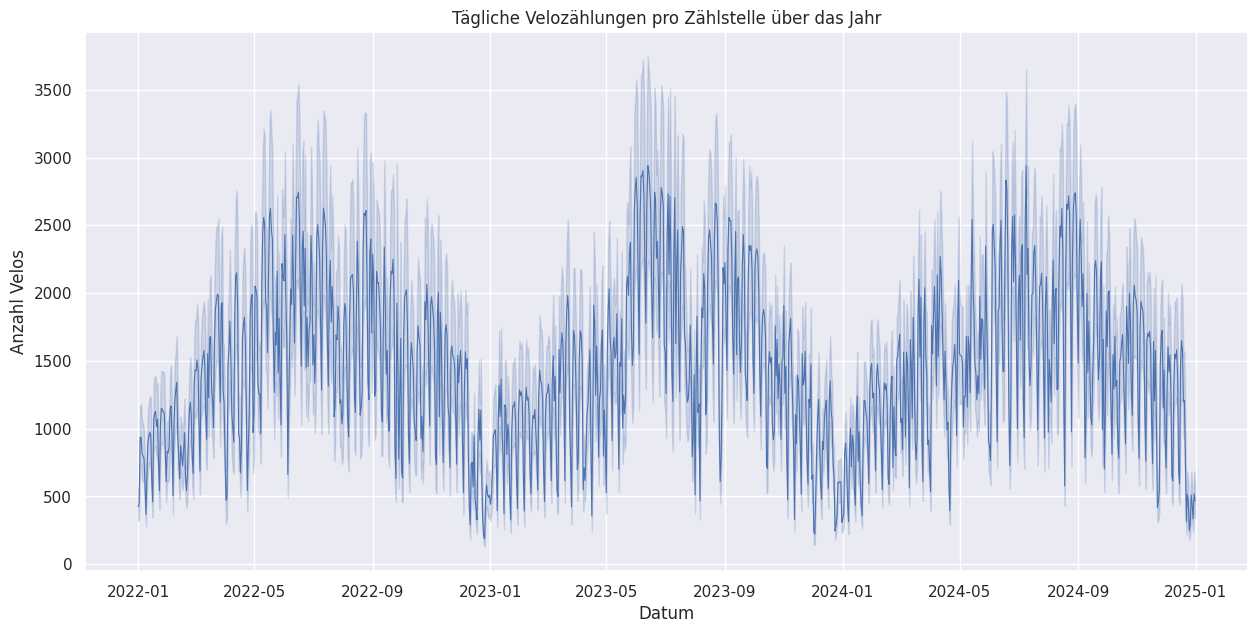

In [ ]:
#Grafik macht grundsätzlich keinen Sinn, nur als erster grober Test

# Plot daily counts for each station
plt.figure(figsize=(15, 7))
sns.lineplot(data=daily_counts, x='Datum', y='Velo', legend=False, linewidth=0.8)
#sns.lineplot(data=daily_counts, x='Datum', y='Velo_Out', hue='Standort_ID', legend=False, linestyle='--', linewidth=0.6)

plt.title('Tägliche Velozählungen pro Zählstelle über das Jahr')
plt.xlabel('Datum')
plt.ylabel('Anzahl Velos')
plt.grid(True)
plt.show()

In [ ]:
num_stations = daily_counts['Standort_ID'].nunique()
print(f'Die Gesamtzahl der Zählstellen beträgt: {num_stations}')

Die Gesamtzahl der Zählstellen beträgt: 37


**Kombination der Daten**

In [ ]:
# Merge daily counts with weather data on the 'Datum' column
merged_data = pd.merge(daily_counts, weather, on='Datum', how='outer')

# Add weekday and weekend columns
merged_data['weekday'] = merged_data['Datum'].dt.weekday
merged_data['weekend'] = (merged_data['weekday'] >= 5).astype(int)
merged_data['weekend'] = merged_data['weekend'].astype(bool)

# Merge with holiday_status using its 'Datum' column
merged_data = pd.merge(merged_data, holiday_status[['Datum', 'is_holiday']], on='Datum', how='left')

# Display the first few rows of the merged dataframe

#display(merged_data.tail(10))


In [ ]:
# Drop the specified columns
data_for_model = merged_data.drop(['Datum','Zeitstempel','Velo_In', 'Velo_Out', 'Koord_Ost', 'Koord_Nord', 'Temperatur min', 'Temperatur max'], axis=1).copy()


,Standort_ID,Velo,year,day_of_year,Niederschlag,Temperatur Durchschnitt,weekday,weekend,is_holiday
0,60,134.0,2022,1,0.0,2.6,5,True,True
1,732,447.0,2022,1,0.0,2.6,5,True,True
2,1037,1141.0,2022,1,0.0,2.6,5,True,True
3,2977,259.0,2022,1,0.0,2.6,5,True,True
4,2978,97.0,2022,1,0.0,2.6,5,True,True
5,2979,206.0,2022,1,0.0,2.6,5,True,True
6,2980,550.0,2022,1,0.0,2.6,5,True,True
7,2982,306.0,2022,1,0.0,2.6,5,True,True
8,2986,339.0,2022,1,0.0,2.6,5,True,True
9,2989,1213.0,2022,1,0.0,2.6,5,True,True
